In [6]:
#Setup
import rioxarray
min_date = '2022-09-01' # Start time
max_date = '2023-10-01' # End time
thuanhoa_path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"
VH_file = "ThuanHoa/ThuanHoa_VH.tif"
VV_file = "ThuanHoa/ThuanHoa_VV.tif"
min_longitude, max_longitude = (105.86575, 105.94120)
min_latitude, max_latitude = (9.65070, 9.69850)
product = 's2_l2a'

In [21]:
%%time
# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Common imports and settings
import os, sys
os.environ['USE_PYGEOS'] = '0'
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr

# Datacube
import datacube
from datacube.utils.rio import configure_s3_access
from datacube.utils import masking
from datacube.utils.cog import write_cog
# https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
from dea_tools.plotting import display_map, rgb
from dea_tools.datahandling import mostcommon_crs

# EASI defaults
easinotebooksrepo = '/home/kaito/CSIROBoeingPhase4-Vietnam/easi-notebooks'
if easinotebooksrepo not in sys.path: sys.path.append(easinotebooksrepo)
from easi_tools import EasiDefaults, xarray_object_size, notebook_utils, unset_cachingproxy
from easi_tools.load_s2l2a import load_s2l2a_with_offset

# Data tools
import numpy as np
from datetime import datetime

# Datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_masking.py
from odc.algo import xr_reproject   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_warp.py
from datacube.utils.geometry import GeoBox, box  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/geometry/_base.py

# Holoviews, Datashader and Bokeh
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import panel as pn
import colorcet as cc
# import cartopy.crs as ccrs
# from datashader import reductions
from holoviews import opts
from utils import load_data_geo
import rasterio
import os
import rioxarray
# import geoviews as gv
# from holoviews.operation.datashader import rasterize
hv.extension('bokeh', logo=False)

from deafrica_tools.bandindices import calculate_indices
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import joblib

CPU times: user 47.7 ms, sys: 1.98 ms, total: 49.6 ms
Wall time: 48.7 ms


In [ ]:

# Dask gateway

cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
client

In [ ]:
import datacube
dc = datacube.Datacube()

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [ ]:
query = {
    'product': product,                     # Product name
    'x': (min_longitude, max_longitude),    # "x" axis bounds
    'y': (min_latitude, max_latitude),      # "y" axis bounds
    'time': (min_date, max_date),           # Any parsable date strings
}


In [ ]:
# Most common CRS
native_crs = notebook_utils.mostcommon_crs(dc, query)
print(f'Most common native CRS: {native_crs}')

In [ ]:
measurements = ['blue', 'green', 'red', 'nir', 'scl']

load_params = {
    'measurements': measurements,                   # Selected measurement or alias names
    'output_crs': native_crs,                       # Target EPSG code
    'resolution': (-10, 10),                        # Target resolution
    'group_by': 'solar_day',                        # Scene grouping
    'dask_chunks': {'x': 2048, 'y': 2048},          # Dask chunks
}

In [ ]:
%%time
# The replacement "dc.load()" function for this product
data = load_s2l2a_with_offset(
    dc,
    query | load_params   # Combine the two dicts that contain our search and load parameters
)

# This line prints the total size of the dataset hat was loaded
notebook_utils.heading(notebook_utils.xarray_object_size(data))

display(data)

In [24]:
flag_name = 'scl'
flag_desc = masking.describe_variable_flags(data[flag_name])  # Pandas dataframe
display(flag_desc)
display(flag_desc.loc['qa'].values[1])

NameError: name 'data' is not defined

In [ ]:
# Create a "data quality" Mask layer
flags_def = flag_desc.loc['qa'].values[1]
good_pixel_flags = [flags_def[str(i)] for i in [2, 4, 5, 6]]  # To pass strings to enum_to_bool()

# enum_to_bool calculates the pixel-wise "or" of each set of pixels given by good_pixel_flags
# 1 = good data
# 0 = "bad" data

good_pixel_mask = enum_to_bool(data[flag_name], good_pixel_flags)  # -> DataArray
# display(good_pixel_mask)  # Type: bool

In [ ]:
data_layer_names = [x for x in data.data_vars if x != 'scl']
rs = []
for layer_name in data_layer_names:
    # Apply valid mask (calculated above) and good pixel mask
    # layer = data[[layer_name]].where(valid_mask[layer_name] & good_pixel_mask)
    layer = data[[layer_name]].where(good_pixel_mask)
    rs.append(layer)
    
# Calculate intermediate result
result = xr.merge(rs).persist()

In [ ]:
from dask.distributed import wait, progress

progress(result)

### Calculate NDVI based on monthly average

In [3]:
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
average_ndvi = ndvi.resample(time='1M').mean().persist()  ## tính mean cho từng tháng -> time = 13
average_ndvi  # DataArray

NameError: name 'calculate_indices' is not defined

### Filled with Nan value

In [ ]:
average_ndvi = average_ndvi.compute()
plt.imshow(average_ndvi.isel(time=5))

In [ ]:
filled_ds = average_ndvi.bfill(dim='time')
filled_ds = filled_ds.ffill(dim='time')
plt.imshow(filled_ds.isel(time=5))

### Load VH, VV

In [7]:
dsvv = rioxarray.open_rasterio(VV_file)
dsvh = rioxarray.open_rasterio(VH_file)

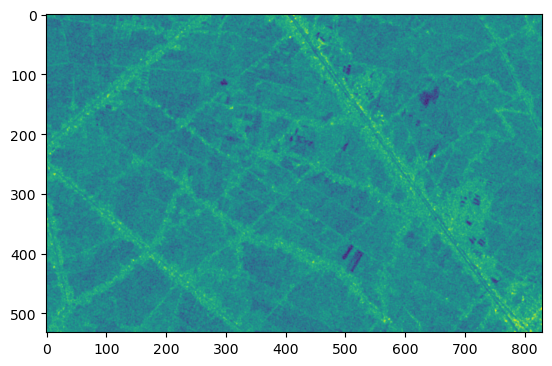

In [10]:
import matplotlib.pyplot as plt
plt.imshow(dsvh.isel(band=5))

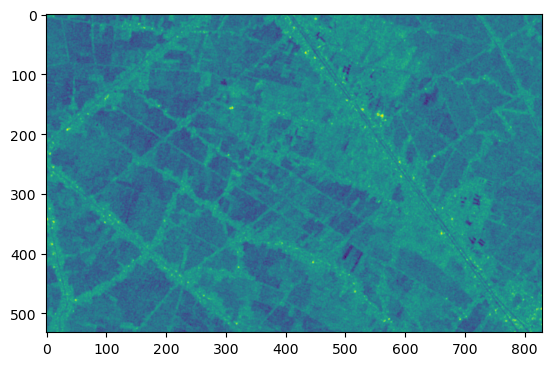

In [11]:
plt.imshow(dsvv.isel(band=5))

### Load training model and predict

In [12]:
import joblib
import numpy as np
dir_save_model = "model_train"

data_predict = []
for i in range(filled_ds.shape[1]):
    ndvi_tmp = filled_ds.isel(y=i).values
    vh_data = dsvh.sel(y=filled_ds.y.values[i], method='nearest').values
    vv_data = dsvv.sel(y=filled_ds.y.values[i], method='nearest').values
    all_tmp = np.concatenate((ndvi_tmp, vh_data, vv_data), axis=0)
    data_predict.extend(all_tmp.T)


loaded_model = joblib.load(os.path.join(dir_save_model, "model.joblib"))
y_pred = loaded_model.predict(data_predict)
final_label = y_pred.reshape(filled_ds.y.shape[0], filled_ds.x.shape[0])

NameError: name 'filled_ds' is not defined

### Convert array result to xarray result

In [ ]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
import rioxarray

final_xarray_save = xr.DataArray(final_label, dims=("y", "x"))
final_xarray_save = final_xarray_save.rio.write_crs(data.rio.crs)

x_values = average_ndvi.x.values
y_values = average_ndvi.y.values

data_array = xr.DataArray(final_xarray_save,
                          coords={'x': x_values, 'y': y_values},
                          dims=['y', 'x'])
data_array = data_array.rio.write_crs(average_ndvi.rio.crs)

### Load shape file Thuan Hoa

In [13]:
from shapely.geometry import Point, Polygon
import geopandas as gpd


gdf = gpd.read_file(thuanhoa_path)
gdf = gdf.to_crs(average_ndvi.rio.crs)
polygon_coords = list(gdf.geometry.values[0].exterior.coords)
polygon_coordinates = [(x, y) for x, y in polygon_coords]

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [polygon_coordinates]
    }
]

NameError: name 'average_ndvi' is not defined

In [ ]:
gdf.geometry.plot()

### Define color and label

In [14]:
from matplotlib.colors import ListedColormap
## label color
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

In [15]:
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

NameError: name 'data_array' is not defined

### Crop the result according to the Thuan Hoa boundary

In [ ]:
region_result = data_array.rio.clip(geometries, data_array.rio.crs, drop=False)
region_result = region_result.where(region_result >= 0, float('nan'))

In [ ]:
cmap = ListedColormap(colors)
img = region_result.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [ ]:
# Example using Hvplot and Holoviews
# for dynamic plots (zoom, scroll)

import hvplot.xarray
from holoviews import opts
from datashader import reductions
from bokeh.models.tickers import FixedTicker

colorval = list(range(len(colors)))
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
region_result.hvplot(
    rasterize = True,                        # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

In [ ]:
region_result.rio.to_raster("KetQuaPhanLoaiDat.tif")

In [ ]:
client.close()
cluster.close()